## L5-E2 Movie Recomendation System using word embedding techniques

Install and import required denpendencies and frameworks

In [1]:
!pip install tf-keras

  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
Using cached keras-3.12.0-py3-none-any.whl (1.5 MB)


In [39]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import re
import gensim.downloader
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from transformers import BertTokenizer, TFBertForSequenceClassification, pipeline, TFBertModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.model_selection import train_test_split
from scipy.special import softmax

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

nltk.data.path.append(r'C:\Users\juanq\Desktop\repo\.venv\nltk_data')
nltk.download('punkt', download_dir=r'C:\Users\juanq\Desktop\repo\.venv\nltk_data')
nltk.download('stopwords', download_dir=r'C:\Users\juanq\Desktop\repo\.venv\nltk_data')
nltk.download('wordnet', download_dir=r'C:\Users\juanq\Desktop\repo\.venv\nltk_data')

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juanq\Desktop\repo\.venv\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanq\Desktop\repo\.venv\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanq\Desktop\repo\.venv\nltk_data...


### 1. Load dataset

In [40]:
path = 'dataset/tmdb_5000_movies.csv'
df = pd.read_csv(path)
df.sample(2)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
4495,609000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10402, ""...",NaN,3080,"[{""id"": 110, ""name"": ""venice""}, {""id"": 1691, ""...",en,Top Hat,Showman Jerry Travers is working for producer ...,3.898498,"[{""name"": ""RKO Radio Pictures"", ""id"": 6}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1935-09-06,3202000,101.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,They're Dancing Cheek-To-Cheek Again!,Top Hat,7.4,59
1309,35000000,"[{""id"": 80, ""name"": ""Crime""}, {""id"": 35, ""name...",NaN,10833,"[{""id"": 206718, ""name"": ""cons and scams""}]",en,Heartbreakers,Max and Page are a brilliant mother/daughter c...,13.932203,"[{""name"": ""Davis Entertainment"", ""id"": 1302}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2001-03-23,0,123.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Caution: Dangerous Curves Ahead,Heartbreakers,5.7,254


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [42]:
df.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
dtype: int64

Select the features -> title & sinopsis

In [43]:
df_features = df[['title','overview']]
df_features.head(2)

,title,overview
0,Avatar,"In the 22nd century, a paraplegic Marine is di..."
1,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha..."


### 2. Preprocessing 

2.1 Data cleaning -> drop the rows where the columns is a null value or empty

In [44]:
df_features.isnull().sum()

title       0
overview    3
dtype: int64

In [45]:
df_features = df_features[df_features['overview'].notna()]
df_features = df_features[df_features['overview'].str.strip() != '']
df_features.isnull().sum()

title       0
overview    0
dtype: int64

2.2 Text Preprocessing

Convert text to lowercase, delete special characters and numbers, tokenize, delete stopwords, steming

In [46]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


def text_preprocessing(text):

    text = text.lower() #conver to lowercase

    text = re.sub(r'[^a-z\s]', '', text) #delete special characters and numbers

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words] #ignore stopwords

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    text = ' '.join(tokens)

    return text






In [48]:
import re

basic_stopwords = {'the','a','an','and','is','it','in','to','of','for','on','with','this','that'}

def preprocess_text_light(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in basic_stopwords]
    return ' '.join(tokens)

df_features['overview_clean'] = df_features['overview'].apply(preprocess_text_light)


In [55]:
df_features['overview_clean'] = df_features['overview'].apply(preprocess_text_light)
df_features.drop(columns='overview',axis=1)

,title,overview_clean
0,Avatar,nd century paraplegic marine dispatched moon p...
1,Pirates of the Caribbean: At World's End,captain barbossa long believed be dead has com...
2,Spectre,cryptic message from bonds past sends him trai...
3,The Dark Knight Rises,following death district attorney harvey dent ...
4,John Carter,john carter warweary former military captain w...
...,...,...
4798,El Mariachi,el mariachi just wants play his guitar carry f...
4799,Newlyweds,newlywed couples honeymoon upended by arrivals...
4800,"Signed, Sealed, Delivered",signed sealed delivered introduces dedicated q...
4801,Shanghai Calling,when ambitious new york attorney sam sent shan...


### 3. Compute Similarity

1. Using cosine similarity

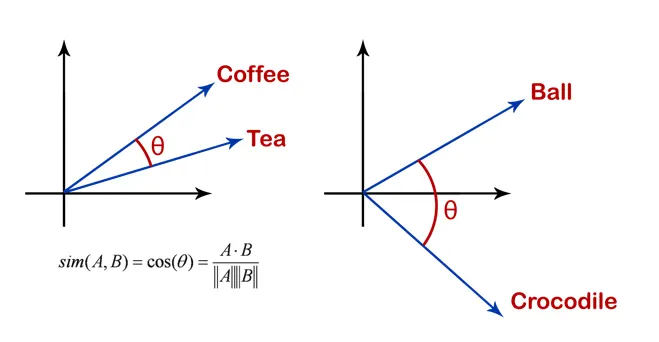

Load light pretrained model -> 128Mb

In [56]:
import gensim.downloader as api

wv = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


Computes average of vectors per document

In [57]:
def doc_vector(tokens,wv,dim = 100):

    vecs = [wv[w] for w in tokens if w in wv]

    if not vecs:
        return np.zeros(dim,dtype = np.float32)
    
    return np.mean(vecs,axis=0)



In [58]:
DIM = wv.vector_size
X = np.vstack(df_features['overview_clean'].fillna("")
              .apply(lambda s: doc_vector(s.split(), wv, dim=DIM)).to_numpy())

X.shape  # (n_peliculas, DIM)

(4799, 100)

### 4. Cosine based recommender

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

S = cosine_similarity(X) #similarity matrix 

def recomendate(idx, k = 10):
    sims = S[idx]
    top = sims.argsort()[::-1]
    top = [j for j in top if j != idx][:k]
    return df_features.iloc[top][['title','overview']]

In [69]:

print('Peliculas recomendadas para: ', df_features['title'][2])
recomendate(2)

Peliculas recomendadas para:  Spectre


,title,overview
1894,War,FBI agent Jack Crawford is out for revenge whe...
97,Shin Godzilla,From the mind behind Evangelion comes a hit la...
626,The X Files,"Mulder and Scully, now taken off the FBI's X F..."
2295,Firestorm,A crew of seasoned criminals led by the notori...
163,Watchmen,In a gritty and alternate 1985 the glory days ...
29,Skyfall,When Bond's latest assignment goes gravely wro...
708,Maze Runner: The Scorch Trials,Thomas and his fellow Gladers face their great...
1892,The Losers,"A tale of double cross and revenge, centered u..."
2958,Saw V,Detective Hoffman is seemingly the last person...
2080,Tinker Tailor Soldier Spy,"Recently-retired MI6 agent, George Smiley is d..."
